# Глубокое обучение на MNIST: Сравнение архитектур нейронных сетей

Этот notebook демонстрирует сравнение различных архитектур сверточных нейронных сетей на датасете MNIST.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import top_k_accuracy_score, accuracy_score, classification_report, confusion_matrix
from scipy.stats import entropy as scipy_entropy
from torchmetrics.classification import MulticlassCalibrationError
import warnings
import time
warnings.filterwarnings('ignore')

In [3]:
# Настройка устройства для вычислений
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

Используется устройство: cpu


## 1. Загрузка и подготовка данных (MNIST)

In [4]:
def load_mnist_data(batch_size=128, val_split=0.1):
    """
    Загрузка и подготовка датасета MNIST с разделением на train/validation/test

    MNIST содержит 70,000 изображений рукописных цифр 28x28 пикселей в оттенках серого:
    - цифры от 0 до 9 (10 классов)
    - 1 канал цвета (grayscale), в отличие от CIFAR-10 с 3 каналами

    Args:
        batch_size: размер батча (количество изображений, обрабатываемых за раз)
        val_split: доля валидационного набора от обучающего (0.1 = 10%)
    """

    # Определяем трансформации для обучающего набора (с аугментацией)
    # Аугментация - это искусственное увеличение датасета путем трансформаций
    # Это помогает модели лучше обобщаться на новые данные
    transform_train = transforms.Compose([
        # RandomRotation: случайно поворачивает изображение (полезно для цифр)
        transforms.RandomRotation(degrees=10),
        # RandomAffine: случайно сдвигает и масштабирует изображение
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),  # Конвертация в тензор PyTorch
        # Нормализация: приведение значений пикселей к стандартному распределению
        # Среднее и std для MNIST вычислены заранее по всему датасету
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Трансформации для валидационного и тестового наборов (без аугментации)
    # На валидации и тесте мы хотим оценить модель на "реальных" данных
    transform_val_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Загрузка исходных данных MNIST
    full_train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform_train
    )
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform_val_test
    )

    # Разделение обучающего набора на train и validation
    # Валидация нужна для мониторинга обучения и предотвращения переобучения
    train_size = int((1 - val_split) * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size

    # Создание генератора для воспроизводимого разделения
    # Это гарантирует, что каждый раз мы получаем одинаковое разделение
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset_temp = torch.utils.data.random_split(
        full_train_dataset, [train_size, val_size], generator=generator
    )

    # Создание отдельного датасета для валидации без аугментации
    # На валидации аугментация может искажать оценку качества
    val_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=False, transform=transform_val_test
    )

    # Получение индексов для валидационного набора
    val_indices = val_dataset_temp.indices
    val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

    # Создание загрузчиков данных (DataLoader)
    # DataLoader разбивает данные на батчи и позволяет итерировать по ним
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Названия классов MNIST (цифры от 0 до 9)
    classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

    print(f"Размеры наборов данных:")
    print(f"  - Обучающий: {len(train_dataset)} образцов")
    print(f"  - Валидационный: {len(val_dataset)} образцов")
    print(f"  - Тестовый: {len(test_dataset)} образцов")

    return train_loader, val_loader, test_loader, classes

## 2. Определение архитектур нейронных сетей

In [5]:
class SimpleCNN_MNIST(nn.Module):
    """
    Простая сверточная нейронная сеть для классификации MNIST

    ОСОБЕННОСТИ ЭТОЙ АРХИТЕКТУРЫ:
    - 3 сверточных слоя с увеличивающимся количеством фильтров (32 -> 64 -> 128)
    - MaxPooling после каждого свертки для уменьшения размерности
    - 2 полносвязных слоя в конце
    - Dropout для предотвращения переобучения
    - Простая и быстрая в обучении, но может быть недостаточно мощной для сложных задач
    """

    def __init__(self, num_classes=10):
        super(SimpleCNN_MNIST, self).__init__()

        # Сверточные слои
        # Conv2d(входные_каналы, выходные_каналы, размер_ядра, padding)
        # MNIST имеет 1 канал (grayscale), в отличие от CIFAR-10 с 3 каналами
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)     # 28x28x1 -> 28x28x32
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)    # 28x28x32 -> 28x28x64
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)   # 14x14x64 -> 14x14x128

        # Пулинг и активация
        self.pool = nn.MaxPool2d(2, 2)  # Уменьшает размер в 2 раза
        self.relu = nn.ReLU()           # Функция активации ReLU: max(0, x)
        self.dropout = nn.Dropout(0.5) # Случайно "выключает" 50% нейронов

        # Полносвязные слои
        # После 3 пулингов: 28 -> 14 -> 7 -> 3.5 (округляем до 3)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # 128 каналов * 3x3 = 1152 -> 256
        self.fc2 = nn.Linear(256, 64)           # 256 -> 64
        self.fc3 = nn.Linear(64, num_classes)   # 64 -> 10 классов

    def forward(self, x):
        # Сверточные слои с активацией и пулингом
        x = self.pool(self.relu(self.conv1(x)))  # 28x28x32 -> 14x14x32
        x = self.pool(self.relu(self.conv2(x)))  # 14x14x64 -> 7x7x64
        x = self.pool(self.relu(self.conv3(x)))  # 7x7x128 -> 3x3x128

        # Преобразование в одномерный вектор для полносвязных слоев
        x = x.view(x.size(0), -1)  # Flatten: batch_size x (128*3*3)

        # Полносвязные слои с dropout
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Выходной слой (логиты для 10 классов)

        return x

In [6]:
class AdvancedCNN(nn.Module):
    """
    Улучшенная сверточная нейронная сеть с Batch Normalization

    ОСОБЕННОСТИ ЭТОЙ АРХИТЕКТУРЫ:
    - Batch Normalization после каждого сверточного слоя (стабилизирует обучение)
    - Больше фильтров в сверточных слоях (64 -> 128 -> 256 -> 512)
    - Дополнительный полносвязный слой
    - Более сложная архитектура, лучше качество, но дольше обучение
    - BatchNorm помогает с internal covariate shift и позволяет использовать больший learning rate
    """

    def __init__(self, num_classes=10):
        super(AdvancedCNN, self).__init__()

        # Сверточные блоки с BatchNorm
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # Batch Normalization

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        # Пулинг и активация
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # Полносвязные слои (после 4 пулингов: 28 -> 14 -> 7 -> 3 -> 1)
        self.fc1 = nn.Linear(512 * 1 * 1, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Сверточные блоки с BatchNorm
        x = self.pool(self.relu(self.bn1(self.conv1(x))))  # 28x28x64 -> 14x14x64
        x = self.pool(self.relu(self.bn2(self.conv2(x))))  # 14x14x128 -> 7x7x128
        x = self.pool(self.relu(self.bn3(self.conv3(x))))  # 7x7x256 -> 3x3x256
        x = self.pool(self.relu(self.bn4(self.conv4(x))))  # 3x3x512 -> 1x1x512

        # Flatten
        x = x.view(x.size(0), -1)

        # Полносвязные слои
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)

        return x

In [7]:
class ResNetBlock(nn.Module):
    """
    Residual блок для ResNet-подобной архитектуры

    ОСОБЕННОСТИ RESIDUAL CONNECTIONS:
    - Пропускают вход напрямую к выходу блока
    - Помогают бороться с vanishing gradient в глубоких сетях
    - Позволяют строить сети с десятками слоев
    """

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()

        # Основной путь
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Residual connection (остаточная связь)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # Если размеры не совпадают, используем 1x1 свертку для подгонки
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.ReLU()

    def forward(self, x):
        # Основной путь
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Residual connection: F(x) + x
        out += self.shortcut(x)
        out = self.relu(out)

        return out


class ResNetLike(nn.Module):
    """
    ResNet-подобная архитектура для MNIST

    ОСОБЕННОСТИ ЭТОЙ АРХИТЕКТУРЫ:
    - Использует residual блоки для глубокого обучения
    - Может иметь много слоев без degradation качества
    - Лучше всего подходит для сложных задач
    - Требует больше вычислений, но дает лучшее качество
    """

    def __init__(self, num_classes=10):
        super(ResNetLike, self).__init__()

        # Начальный слой
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # Residual блоки
        self.layer1 = self._make_layer(64, 64, 2, stride=1)    # 2 блока по 64 канала
        self.layer2 = self._make_layer(64, 128, 2, stride=2)   # 2 блока по 128 каналов
        self.layer3 = self._make_layer(128, 256, 2, stride=2)  # 2 блока по 256 каналов

        # Пулинг и классификатор
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Глобальный average pooling
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        """Создает последовательность residual блоков"""
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))

        for _ in range(1, num_blocks):
            layers.append(ResNetBlock(out_channels, out_channels, stride=1))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Начальный слой
        x = self.relu(self.bn1(self.conv1(x)))  # 28x28x64

        # Residual блоки
        x = self.layer1(x)  # 28x28x64
        x = self.layer2(x)  # 14x14x128
        x = self.layer3(x)  # 7x7x256

        # Глобальный pooling и классификатор
        x = self.avgpool(x)  # 1x1x256
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.fc(x)

        return x

## 3. Функции обучения и оценки

In [8]:
def validate_model(model, val_loader, criterion, device):
    """
    Валидация модели (оценка на валидационном наборе)
    """
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    return avg_val_loss, val_accuracy

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    """
    Обучение модели с валидацией и отслеживанием метрик
    """
    # Списки для хранения метрик
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Для раннего останова (early stopping)
    best_val_accuracy = 0.0
    patience = 3  # Количество эпох без улучшения
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        # ====================================================================
        # ОБУЧЕНИЕ
        # ====================================================================
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            # Перемещение данных на устройство
            inputs, labels = inputs.to(device), labels.to(device)

            # Обнуление градиентов
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            # Статистика
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Метрики обучения за эпоху
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # ====================================================================
        # ВАЛИДАЦИЯ
        # ====================================================================
        val_loss, val_accuracy = validate_model(
            model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Печать метрик эпохи
        print(f'Эпоха [{epoch+1}/{num_epochs}]:')
        print(
            f'  Обучение  - Потеря: {train_loss:.4f}, Точность: {train_accuracy:.2f}%')
        print(
            f'  Валидация - Потеря: {val_loss:.4f}, Точность: {val_accuracy:.2f}%')
        print('-' * 60)

        # Проверка на улучшение (для early stopping)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
            # Здесь можно сохранить лучшую модель
            print(
                f'  ✅ Новая лучшая валидационная точность: {best_val_accuracy:.2f}%')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'  ⏹️ Ранний останов: {patience} эпох без улучшения')
                break

        print()

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_accuracy': best_val_accuracy
    }

In [10]:
def evaluate_model_with_metrics(model, test_loader, device, classes):
    """
    Комплексная оценка модели с различными метриками
    """
    model.eval()

    # Списки для хранения результатов
    all_predictions = []
    all_labels = []
    all_softmax_probs = []
    all_logits = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Получение логитов (сырых выходов)
            logits = model(inputs)

            # Применение softmax для получения вероятностей
            softmax_probs = torch.softmax(logits, dim=1)

            # Получение предсказаний
            _, predicted = torch.max(logits, 1)

            # Сохранение результатов
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_softmax_probs.extend(softmax_probs.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())

    # Преобразование в numpy массивы для удобства
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_softmax_probs = np.array(all_softmax_probs)
    all_logits = np.array(all_logits)

    return all_predictions, all_labels, all_softmax_probs, all_logits

## 4. Функции для вычисления метрик

In [11]:
def calculate_confidence_scores(softmax_probs):
    """
    Вычисление confidence scores как максимальной вероятности
    """
    confidence_scores = np.max(softmax_probs, axis=1)
    return confidence_scores


def calculate_top_k_accuracy(softmax_probs, true_labels, k=5):
    """
    Вычисление Top-K accuracy
    """
    acc = top_k_accuracy_score(true_labels, softmax_probs, k=k)
    return acc * 100.0


def calculate_entropy(softmax_probs):
    """
    Вычисление энтропии для измерения неопределенности
    H = -∑ p_i * log(p_i)
    """
    # Добавление малого значения для избежания log(0)
    ent = scipy_entropy(softmax_probs, axis=1)
    return ent


def calculate_calibration_error(softmax_probs, predictions, true_labels, n_bins=10):
    """
    Вычисление Expected Calibration Error (ECE)
    Измеряет соответствие между уверенностью модели и реальной точностью
    """
    probs_t = torch.from_numpy(softmax_probs).float()      # shape: [N, C]
    targets_t = torch.from_numpy(true_labels).long()       # shape: [N]

    # ECE с L1-нормой (|conf - acc|), как у тебя было
    ece_metric = MulticlassCalibrationError(
        num_classes=softmax_probs.shape[1],
        n_bins=n_bins,
        norm='l1'
    )
    ece = float(ece_metric(probs_t, targets_t).item())

    # bin_data не нужен — возвращаем пустой список, чтобы не менять сигнатуры
    return ece, []

## 5. Функции визуализации

In [12]:
def plot_training_history(training_history):
    """
    Построение графиков обучения и валидации (с лентами диапазона)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # --- единый стиль
    FIGSIZE = (12, 5)
    GRID_ALPHA = 0.3
    BAND_ALPHA = 0.15
    LINEWIDTH = 2

    train_accuracies = np.asarray(
        training_history['train_accuracies'], dtype=float)
    val_accuracies = np.asarray(
        training_history['val_accuracies'],   dtype=float)
    train_losses = np.asarray(
        training_history['train_losses'],     dtype=float)
    val_losses = np.asarray(training_history['val_losses'],       dtype=float)
    epochs = np.arange(1, len(train_accuracies) + 1)

    def _smooth(x, k=3):
        if len(x) < k:
            return x
        w = np.ones(k)/k
        y = np.convolve(x, w, mode='valid')
        pad = (len(x) - len(y)) // 2
        return np.pad(y, (pad, len(x)-len(y)-pad), mode='edge')

    def _roll_minmax(x, k=5):
        if k < 2 or len(x) < k:
            return x, x
        from collections import deque
        dmin, dmax, qmin, qmax, xs = [], [], deque(), deque(), x.tolist()
        for i, v in enumerate(xs):
            while qmin and xs[qmin[-1]] >= v:
                qmin.pop()
            qmin.append(i)
            while qmax and xs[qmax[-1]] <= v:
                qmax.pop()
            qmax.append(i)
            if qmin[0] <= i-k:
                qmin.popleft()
            if qmax[0] <= i-k:
                qmax.popleft()
            dmin.append(xs[qmin[0]])
            dmax.append(xs[qmax[0]])
        return np.array(dmin), np.array(dmax)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE)

    # --- Точность
    tr_s = _smooth(train_accuracies, k=3)
    va_s = _smooth(val_accuracies,   k=3)
    ax1.plot(epochs, tr_s, linewidth=LINEWIDTH, label='Обучение')
    ax1.plot(epochs, va_s, linewidth=LINEWIDTH, label='Валидация')
    tr_lo, tr_hi = _roll_minmax(train_accuracies, k=5)
    va_lo, va_hi = _roll_minmax(val_accuracies,   k=5)
    ax1.fill_between(epochs, tr_lo, tr_hi, alpha=BAND_ALPHA)
    ax1.fill_between(epochs, va_lo, va_hi, alpha=BAND_ALPHA)
    ax1.set_title('Точность по эпохам')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Точность (%)')
    ax1.grid(True, alpha=GRID_ALPHA)
    ax1.legend(loc='lower right')

    # --- Потери
    tl_s = _smooth(train_losses, k=3)
    vl_s = _smooth(val_losses,   k=3)
    ax2.plot(epochs, tl_s, linewidth=LINEWIDTH, label='Обучение')
    ax2.plot(epochs, va_s, linewidth=LINEWIDTH, label='Валидация')
    tl_lo, tl_hi = _roll_minmax(train_losses, k=5)
    vl_lo, vl_hi = _roll_minmax(val_losses,   k=5)
    ax2.fill_between(epochs, tl_lo, tl_hi, alpha=BAND_ALPHA)
    ax2.fill_between(epochs, vl_lo, vl_hi, alpha=BAND_ALPHA)
    ax2.set_title('Потери по эпохам')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Потеря')
    ax2.grid(True, alpha=GRID_ALPHA)
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # --- Анализ переобучения (без изменений)
    print("\n🔍 АНАЛИЗ ПЕРЕОБУЧЕНИЯ:")
    final_train_acc = float(train_accuracies[-1])
    final_val_acc = float(val_accuracies[-1])
    gap = final_train_acc - final_val_acc
    print(f"Финальная точность обучения: {final_train_acc:.2f}%")
    print(f"Финальная точность валидации: {final_val_acc:.2f}%")
    print(f"Разрыв (Train - Val): {gap:.2f}%")
    if gap < 3:
        print("✅ Переобучения практически нет")
    elif gap < 8:
        print("⚠️ Легкое переобучение")
    elif gap < 15:
        print("🔶 Умеренное переобучение")
    else:
        print("❌ Сильное переобучение")
    return gap

In [13]:
def plot_confusion_matrix(true_labels, predictions, classes):
    """
    Построение матрицы ошибок (проценты + абсолюты, нормировка по истине)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    FIGSIZE = (8, 6)
    GRID_ALPHA = 0.3

    cm_abs = confusion_matrix(true_labels, predictions)
    with np.errstate(invalid='ignore'):
        cm = cm_abs / cm_abs.sum(axis=1, keepdims=True)
    cm = np.nan_to_num(cm)

    plt.figure(figsize=FIGSIZE)
    ax = sns.heatmap(cm, annot=False, cmap='Blues',
                     xticklabels=classes, yticklabels=classes,
                     vmin=0.0, vmax=1.0, cbar_kws={"label": "Доля по истинному классу"})
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt = f"{cm[i, j]*100:.1f}%\n({cm_abs[i, j]})"
            ax.text(j+0.5, i+0.5, txt, ha='center',
                    va='center', fontsize=9, color='black')

    plt.title('Матрица путаницы (ошибок)')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.grid(False)  # у heatmap своя сетка
    plt.tight_layout()
    plt.show()

## 6. Главная функция - сравнение архитектур

## 6.1 Загрузка данных и настройка моделей


In [20]:
print("=" * 80)
print("ГЛУБОКОЕ ОБУЧЕНИЕ НА MNIST: СРАВНЕНИЕ АРХИТЕКТУР")
print("=" * 80)

# 1. Загрузка данных MNIST
print("\n1. Загрузка данных MNIST...")
train_loader, val_loader, test_loader, classes = load_mnist_data(
    batch_size=128, val_split=0.1)
print(f"Классы: {classes}")

# Определение моделей для сравнения
models_config = [
    {
        'name': 'SimpleCNN_MNIST',
        'model': SimpleCNN_MNIST(num_classes=10),
        'description': 'Простая CNN с 3 сверточными слоями'
    },
    {
        'name': 'AdvancedCNN',
        'model': AdvancedCNN(num_classes=10),
        'description': 'Улучшенная CNN с BatchNorm и 4 сверточными слоями'
    },
    {
        'name': 'ResNetLike',
        'model': ResNetLike(num_classes=10),
        'description': 'ResNet-подобная архитектура с residual блоками'
    }
]

# Словарь для хранения результатов всех моделей
all_results = {}


ГЛУБОКОЕ ОБУЧЕНИЕ НА MNIST: СРАВНЕНИЕ АРХИТЕКТУР

1. Загрузка данных MNIST...
Размеры наборов данных:
  - Обучающий: 54000 образцов
  - Валидационный: 6000 образцов
  - Тестовый: 10000 образцов
Классы: ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


## 6.2 Обучение моделей


In [21]:
# 2. Обучение и оценка каждой модели
for i, config in enumerate(models_config, 1):
    print(f"\n{'='*60}")
    print(f"2.{i} ОБУЧЕНИЕ МОДЕЛИ: {config['name']}")
    print(f"Описание: {config['description']}")
    print(f"{'='*60}")

    model = config['model'].to(device)

    # Подсчет параметров
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Всего параметров в модели: {total_params:,}")

    # Определение функции потерь и оптимизатора
    criterion = nn.CrossEntropyLoss()  # Стандартная функция потерь для классификации
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam - популярный оптимизатор

    # Замер времени обучения
    start_time = time.time()

    # Обучение модели
    training_history = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10
    )

    training_time = time.time() - start_time
    print(f"Время обучения: {training_time:.2f} секунд")
    # Финальная оценка на тестовом наборе
    print(f"\nОценка {config['name']} на тестовом наборе...")
    predictions, true_labels, softmax_probs, logits = evaluate_model_with_metrics(
        model, test_loader, device, classes
    )

    # Базовая точность на тестовом наборе
    test_accuracy = accuracy_score(true_labels, predictions) * 100

    # Сохранение результатов
    all_results[config['name']] = {
        'model': model,
        'training_history': training_history,
        'test_accuracy': test_accuracy,
        'predictions': predictions,
        'true_labels': true_labels,
        'softmax_probs': softmax_probs,
        'training_time': training_time,
        'total_params': total_params
    }

    print(f"🎯 Тестовая точность {config['name']}: {test_accuracy:.2f}%")



2.1 ОБУЧЕНИЕ МОДЕЛИ: SimpleCNN_MNIST
Описание: Простая CNN с 3 сверточными слоями
Всего параметров в модели: 404,938
Эпоха [1/10]:
  Обучение  - Потеря: 0.6240, Точность: 79.86%
  Валидация - Потеря: 0.1185, Точность: 96.73%
------------------------------------------------------------
  ✅ Новая лучшая валидационная точность: 96.73%

Эпоха [2/10]:
  Обучение  - Потеря: 0.1950, Точность: 94.79%
  Валидация - Потеря: 0.0626, Точность: 98.38%
------------------------------------------------------------
  ✅ Новая лучшая валидационная точность: 98.38%

Эпоха [3/10]:
  Обучение  - Потеря: 0.1388, Точность: 96.41%
  Валидация - Потеря: 0.0545, Точность: 98.58%
------------------------------------------------------------
  ✅ Новая лучшая валидационная точность: 98.58%

Эпоха [4/10]:
  Обучение  - Потеря: 0.1150, Точность: 97.02%
  Валидация - Потеря: 0.0478, Точность: 98.77%
------------------------------------------------------------
  ✅ Новая лучшая валидационная точность: 98.77%

Эпоха [5/1

## 6.3 Сравнение архитектур


In [22]:
# 3. СРАВНЕНИЕ МОДЕЛЕЙ
print(f"\n{'='*80}")
print("3. СРАВНЕНИЕ АРХИТЕКТУР")
print(f"{'='*80}")

# Таблица сравнения
print("\n📊 СРАВНИТЕЛЬНАЯ ТАБЛИЦА:")
print("-" * 80)
print(f"{'Модель':<15} {'Параметры':<12} {'Время':<8} {'Вал.':<6} {'Тест':<6}")
print("-" * 80)

best_model_name = None
best_accuracy = 0.0

for name, results in all_results.items():
    params = results['total_params']
    train_time = results['training_time']
    val_acc = results['training_history']['best_val_accuracy']
    test_acc = results['test_accuracy']

    print(f"{name:<15} {params:<12,} {train_time:<8.1f} {val_acc:<6.1f} {test_acc:<6.1f}")

    if test_acc > best_accuracy:
        best_accuracy = test_acc
        best_model_name = name

print("-" * 80)
print(f"🏆 ЛУЧШАЯ МОДЕЛЬ: {best_model_name} (точность: {best_accuracy:.2f}%)")



3. СРАВНЕНИЕ АРХИТЕКТУР

📊 СРАВНИТЕЛЬНАЯ ТАБЛИЦА:
--------------------------------------------------------------------------------
Модель          Параметры    Время    Вал.   Тест  
--------------------------------------------------------------------------------
SimpleCNN_MNIST 404,938      172.2    99.3   99.3  
AdvancedCNN     2,356,554    524.0    99.2   99.2  
ResNetLike      2,778,762    2374.9   99.2   99.2  
--------------------------------------------------------------------------------
🏆 ЛУЧШАЯ МОДЕЛЬ: SimpleCNN_MNIST (точность: 99.31%)


## 6.4 Детальный анализ лучшей модели


In [23]:
# 4. ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ
print(f"\n{'='*60}")
print(f"4. ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: {best_model_name}")
print(f"{'='*60}")

best_results = all_results[best_model_name]
predictions = best_results['predictions']
true_labels = best_results['true_labels']
softmax_probs = best_results['softmax_probs']

# Базовые метрики
print(f"\n📊 БАЗОВЫЕ МЕТРИКИ НА ТЕСТОВОМ НАБОРЕ:")
print(f"Top-1 Accuracy: {best_results['test_accuracy']:.2f}%")

# Confidence Scores
confidence_scores = calculate_confidence_scores(softmax_probs)
avg_confidence = np.mean(confidence_scores)
print(f"Средний Confidence Score: {avg_confidence:.3f}")

# Top-K Accuracy
print(f"\n🎯 TOP-K ACCURACY:")
for k in [1, 3, 5]:
    top_k_acc = calculate_top_k_accuracy(softmax_probs, true_labels, k=k)
    print(f"Top-{k} Accuracy: {top_k_acc:.2f}%")

# Энтропия
entropy_values = calculate_entropy(softmax_probs)
avg_entropy = np.mean(entropy_values)
print(f"\n🔀 ЭНТРОПИЯ (неопределенность):")
print(f"Средняя энтропия: {avg_entropy:.3f}")

# Калибровка
ece, _ = calculate_calibration_error(
    softmax_probs, predictions, true_labels)
print(f"\n⚖️ КАЛИБРОВКА:")
print(f"Expected Calibration Error (ECE): {ece:.3f}")

# Отчет по классам
print(f"\n📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:")
class_report = classification_report(true_labels, predictions,
                                     target_names=classes, digits=3)
print(class_report)



4. ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: SimpleCNN_MNIST

📊 БАЗОВЫЕ МЕТРИКИ НА ТЕСТОВОМ НАБОРЕ:
Top-1 Accuracy: 99.31%
Средний Confidence Score: 0.994

🎯 TOP-K ACCURACY:
Top-1 Accuracy: 99.31%
Top-3 Accuracy: 99.96%
Top-5 Accuracy: 99.98%

🔀 ЭНТРОПИЯ (неопределенность):
Средняя энтропия: 0.018

⚖️ КАЛИБРОВКА:
Expected Calibration Error (ECE): 0.002

📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:
              precision    recall  f1-score   support

           0      0.991     0.998     0.994       980
           1      0.997     0.996     0.996      1135
           2      0.993     0.997     0.995      1032
           3      0.993     0.994     0.994      1010
           4      0.997     0.985     0.991       982
           5      0.994     0.992     0.993       892
           6      0.991     0.995     0.993       958
           7      0.991     0.993     0.992      1028
           8      0.999     0.990     0.994       974
           9      0.984     0.991     0.988      1009

    accuracy               

## 6.5 Визуализация результатов



ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ЛУЧШЕЙ МОДЕЛИ


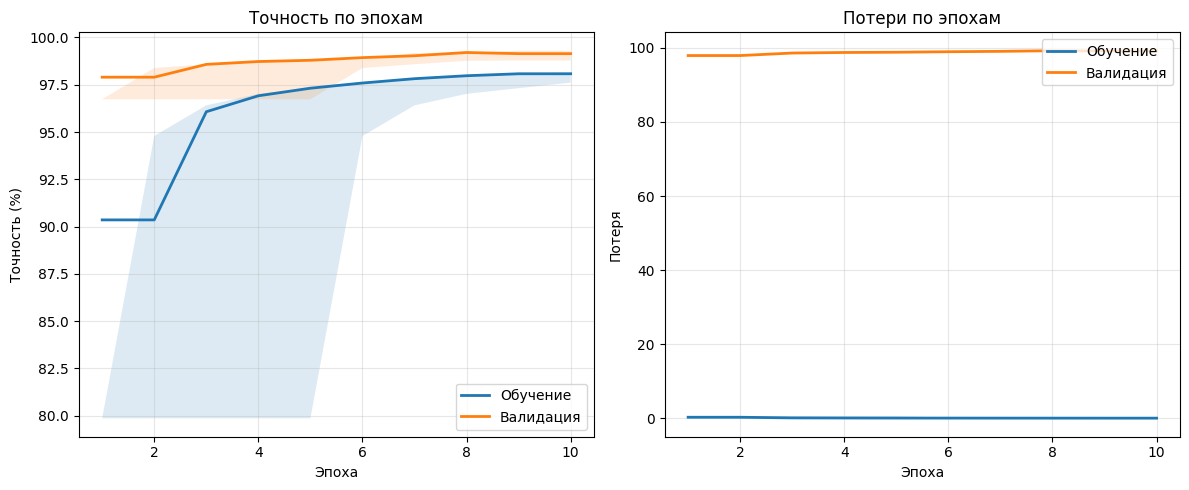


🔍 АНАЛИЗ ПЕРЕОБУЧЕНИЯ:
Финальная точность обучения: 98.15%
Финальная точность валидации: 99.00%
Разрыв (Train - Val): -0.85%
✅ Переобучения практически нет


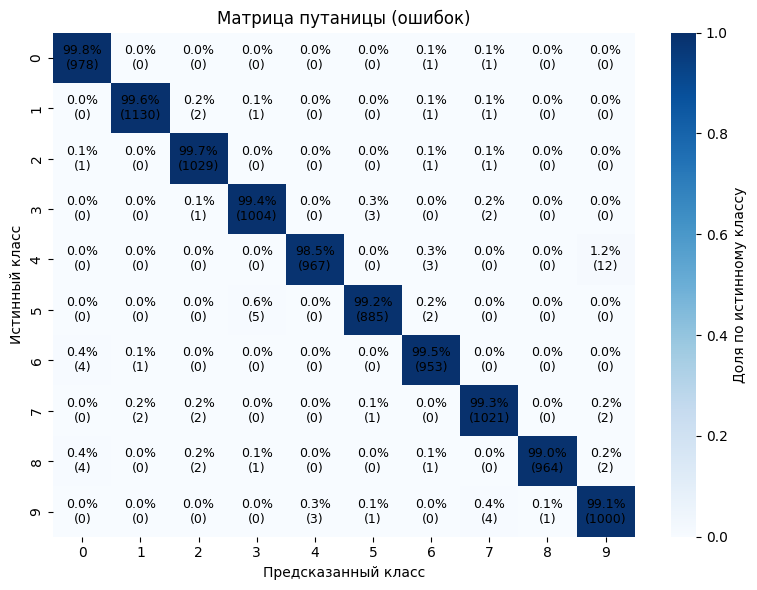

In [24]:
# 5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ЛУЧШЕЙ МОДЕЛИ
print(f"\n{'='*50}")
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ЛУЧШЕЙ МОДЕЛИ")
print(f"{'='*50}")

# График обучения
overfitting_gap = plot_training_history(best_results['training_history'])

# Матрица ошибок
plot_confusion_matrix(true_labels, predictions, classes)


## 6.6 Выводы и рекомендации


In [25]:
# 6. ВЫВОДЫ
print(f"\n{'='*80}")
print("ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print(f"{'='*80}")

print(f"\n🏆 ПОБЕДИТЕЛЬ: {best_model_name}")
print(f"   - Тестовая точность: {best_accuracy:.2f}%")
print(f"   - Количество параметров: {best_results['total_params']:,}")
print(f"   - Время обучения: {best_results['training_time']:.2f} секунд")
print(f"\n📈 ОСОБЕННОСТИ КАЖДОЙ АРХИТЕКТУРЫ:")

for name, results in all_results.items():
    test_acc = results['test_accuracy']
    params = results['total_params']
    train_time = results['training_time']

    print(f"\n{name}:")
    print(f"   - Точность: {test_acc:.2f}%")
    print(f"   - Параметры: {params:,}")
    print(f"   - Время обучения: {train_time:.2f} секунд")
    if name == 'SimpleCNN_MNIST':
        print("   - Особенности: Простая архитектура, быстрая в обучении")
        print("   - Когда использовать: Для быстрого прототипирования или ограниченных ресурсов")
    elif name == 'AdvancedCNN':
        print("   - Особенности: BatchNorm для стабильного обучения, больше слоев")
        print("   - Когда использовать: Когда нужна хорошая точность без residual connections")
    elif name == 'ResNetLike':
        print("   - Особенности: Residual блоки позволяют глубокое обучение")
        print("   - Когда использовать: Для достижения максимальной точности")

print(f"\n💡 РЕКОМЕНДАЦИИ:")
print(f"   - Для production используйте {best_model_name}")
print("   - Увеличьте количество эпох для еще лучшего качества")
print("   - Попробуйте другие оптимизаторы (SGD с momentum)")
print("   - Добавьте больше аугментации данных")



ВЫВОДЫ И РЕКОМЕНДАЦИИ

🏆 ПОБЕДИТЕЛЬ: SimpleCNN_MNIST
   - Тестовая точность: 99.31%
   - Количество параметров: 404,938
   - Время обучения: 172.25 секунд

📈 ОСОБЕННОСТИ КАЖДОЙ АРХИТЕКТУРЫ:

SimpleCNN_MNIST:
   - Точность: 99.31%
   - Параметры: 404,938
   - Время обучения: 172.25 секунд
   - Особенности: Простая архитектура, быстрая в обучении
   - Когда использовать: Для быстрого прототипирования или ограниченных ресурсов

AdvancedCNN:
   - Точность: 99.25%
   - Параметры: 2,356,554
   - Время обучения: 523.99 секунд
   - Особенности: BatchNorm для стабильного обучения, больше слоев
   - Когда использовать: Когда нужна хорошая точность без residual connections

ResNetLike:
   - Точность: 99.23%
   - Параметры: 2,778,762
   - Время обучения: 2374.88 секунд
   - Особенности: Residual блоки позволяют глубокое обучение
   - Когда использовать: Для достижения максимальной точности

💡 РЕКОМЕНДАЦИИ:
   - Для production используйте SimpleCNN_MNIST
   - Увеличьте количество эпох для еще лучш